In [1]:
!apt-get install git
!git clone https://github.com/ryanzhumich/AESLC

!pip install transformers
!pip install langchain_community
!pip install langchain
!pip install unstructured
!pip install evaluate
!pip install rouge-score # Installing rouge-score library (https://pypi.org/project/rouge-score/)

!pip install accelerate -U

!pip install transformers[torch]
!pip install sacrebleu

!pip install datasets nltk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'AESLC'...
remote: Enumerating objects: 17469, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 17469 (delta 1), reused 0 (delta 0), pack-reused 17461
Receiving objects: 100% (17469/17469), 7.36 MiB | 6.60 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (18304/18304), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.0/990.0 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.5/373.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.9 MB/s eta 0:00:00
 

In [2]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
import seaborn as sns

from datasets import load_metric
from datasets import Dataset
import shutil

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics & Mathematics
import scipy.stats as stats
# import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, DataCollatorForSeq2Seq, Trainer, TrainingArguments

In [4]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import DirectoryLoader

In [6]:
# from langchain_community.document_loaders import GenericLoader
from langchain_community.document_loaders.blob_loaders import FileSystemBlobLoader


In [7]:
from langchain.document_loaders.text import TextLoader


In [8]:
seed = 42
colormap = 'cividis'
template = 'plotly_dark'

In [10]:
#Function to get folder lenghts

def get_folder_lengths(base_folder):
    folder_lengths = {}
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        if os.path.isdir(folder_path):
            num_files = len(os.listdir(folder_path))
            folder_lengths[folder_name] = num_files
    return folder_lengths


In [14]:
# Check size of raw datafiles

base_folder = '/content/AESLC/enron_subject_line'
folder_lengths = get_folder_lengths(base_folder)

for folder, length in folder_lengths.items():
    print(f"The folder '{folder}' contains {length} files.")

The folder 'train' contains 14436 files.
The folder 'test' contains 1906 files.
The folder 'dev' contains 1960 files.


In [15]:
folder_path = '/content/AESLC/enron_subject_line/train'

In [34]:
#Function to load directory and preprocess the file's content using DirectoryLoader

def load_and_process_directory(directory_path):
    # Initialize the DirectoryLoader
    loader = DirectoryLoader(path=folder_path, glob="**/*.subject", silent_errors=True, show_progress=True, loader_cls=TextLoader)
    emails = loader.load()

    # Extract content from documents
    text_data = [email.page_content for email in emails]

    # Process text data to extract features
    features = extract_features(text_data)

    return features


def extract_features(text_data):
    # Preprocess each document in the text_data
    processed_texts = [preprocess_text(text) for text in text_data]

    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=1000)

    # Fit and transform the processed texts
    features = vectorizer.fit_transform(processed_texts)

    return features

In [17]:
train_loader = DirectoryLoader(path=folder_path, glob="**/*.subject", silent_errors=True, show_progress=True, loader_cls=TextLoader)

In [18]:
train_loader

In [19]:
email_docs = train_loader.load()

100%|██████████| 14436/14436 [00:07<00:00, 1923.23it/s]


In [23]:
len(email_docs)

14436

In [113]:
email_docs

[Document(metadata={'source': '/content/AESLC/enron_subject_line/train/campbell-l_inbox_778.subject'}, page_content="EFCU's E-Survey Results are In!\nThanks to everyone who completed the Credit Union's recent E-Survey.\nWe received over 3,000 responses, and we appreciate the time each of you took to provide us with your honest opinions.\nPlease help us congratulate our contest winner, Rick Loveless, of Amarillo, TX.\nRick is now $200 richer!\nYou will find the results to our E-survey in your e-mail box soon.\n\n@subject\nEFCU - E-Survey Winner Announcement"),
 Document(metadata={'source': '/content/AESLC/enron_subject_line/train/nemec-g_inbox_779.subject'}, page_content="Here is my rendition of our To-do Lists:  \tRusk County  \t\t\tProvide 1) Short circuit mVa, 2) allowable voltage dip, 3) substation design and 1-line diagram \t\t\t\t4) schedule for power line, 5) schedule for substation 6) transformer sizing, efficiency/loss, etc.\nGeneral Electric \t\t\tWill provide an all encompass

In [24]:
email_docs[0]

Document(metadata={'source': '/content/AESLC/enron_subject_line/train/campbell-l_inbox_778.subject'}, page_content="EFCU's E-Survey Results are In!\nThanks to everyone who completed the Credit Union's recent E-Survey.\nWe received over 3,000 responses, and we appreciate the time each of you took to provide us with your honest opinions.\nPlease help us congratulate our contest winner, Rick Loveless, of Amarillo, TX.\nRick is now $200 richer!\nYou will find the results to our E-survey in your e-mail box soon.\n\n@subject\nEFCU - E-Survey Winner Announcement")

In [26]:
email_docs[0].page_content

"EFCU's E-Survey Results are In!\nThanks to everyone who completed the Credit Union's recent E-Survey.\nWe received over 3,000 responses, and we appreciate the time each of you took to provide us with your honest opinions.\nPlease help us congratulate our contest winner, Rick Loveless, of Amarillo, TX.\nRick is now $200 richer!\nYou will find the results to our E-survey in your e-mail box soon.\n\n@subject\nEFCU - E-Survey Winner Announcement"

In [30]:
email_docs[0].metadata,

'/content/AESLC/enron_subject_line/train/campbell-l_inbox_778.subject'

In [31]:
email_docs[0].metadata['source']

'/content/AESLC/enron_subject_line/train/campbell-l_inbox_778.subject'

In [32]:
text_data = [doc.page_content for doc in email_docs]

In [33]:
text_data[0]

"EFCU's E-Survey Results are In!\nThanks to everyone who completed the Credit Union's recent E-Survey.\nWe received over 3,000 responses, and we appreciate the time each of you took to provide us with your honest opinions.\nPlease help us congratulate our contest winner, Rick Loveless, of Amarillo, TX.\nRick is now $200 richer!\nYou will find the results to our E-survey in your e-mail box soon.\n\n@subject\nEFCU - E-Survey Winner Announcement"

In [35]:
def load_and_process_directory(directory_path):
    # Initialize the DirectoryLoader
    train_loader = DirectoryLoader(path=folder_path, glob="**/*.subject", silent_errors=True, show_progress=True, loader_cls=TextLoader)
    email_docs = train_loader.load()

    # Extract and process content from documents
    data = []

    for doc in email_docs:
      extracted_parts = split_text_into_parts(doc.page_content)
      for part in extracted_parts:
          data.append({
              'source': extract_file_name(doc.metadata.get('source', 'unknown')),
              'tag': part.get('tag', 'body'),
              'content': part['content']
          })


    # Create DataFrame
    df = pd.DataFrame(data)

    return df

In [36]:
def extract_lines_with_symbol(text, symbol):
    # Find all lines starting with the symbol and extract the tag and content
    pattern = re.compile(rf'^{re.escape(symbol)}(\w+)\n(.*)', re.MULTILINE)
    matches = pattern.findall(text)

    return {tag: content.strip() for tag, content in matches}

In [38]:
text_data[2]

"Spoke to the tax lady today.\nShe mailed an extension for mine and my fathers  taxes.\nI just know you guys care.\nI mailed all of Dad's tax stuff to her  Sunday and she received it yesterday.\n\n@subject\nTaxes"

In [40]:
#
def split_text_into_parts(text):
    # Split the text into parts as per the criteria
    pattern = re.compile(r'(@\w+)\n')
    parts = pattern.split(text)

    result = []
    current_part = {'tag': 'body', 'content': parts[0].strip()}
    result.append(current_part)

    for i in range(1, len(parts), 2):
        tag = parts[i][1:]  # Remove the @ symbol
        content = parts[i + 1].strip() if i + 1 < len(parts) else ''
        result.append({'tag': tag, 'content': content})

    return result


In [41]:
split_text_into_parts(text_data[2])

[{'tag': 'body',
  'content': "Spoke to the tax lady today.\nShe mailed an extension for mine and my fathers  taxes.\nI just know you guys care.\nI mailed all of Dad's tax stuff to her  Sunday and she received it yesterday."},
 {'tag': 'subject', 'content': 'Taxes'}]

In [42]:
def extract_file_name(file_path):
    # Regex to extract the file name without the extension
    pattern = re.compile(r'/([^/]+)\.[^.]+$')
    match = pattern.search(file_path)
    if match:
        return match.group(1)
    return None

In [43]:
emails_df = load_and_process_directory(folder_path)

100%|██████████| 14436/14436 [00:01<00:00, 8809.82it/s] 


In [45]:
emails_df#.head(10)

,source,tag,content
0,campbell-l_inbox_778,body,EFCU's E-Survey Results are In!\nThanks to eve...
1,campbell-l_inbox_778,subject,EFCU - E-Survey Winner Announcement
2,nemec-g_inbox_779,body,Here is my rendition of our To-do Lists: \tRu...
3,nemec-g_inbox_779,subject,OGS - East Texas Project
4,germany-c_sent_1758,body,Spoke to the tax lady today.\nShe mailed an ex...
...,...,...,...
28869,shackleton-s_sent_977,subject,Telephone conference
28870,hodge-j_inbox_692,body,COLUMBIA GAS TRANSMISSION CORPORATION ...
28871,hodge-j_inbox_692,subject,REVISED TCO - CAPACITY UPDATE EFF FOR NOVEMBE...
28872,tycholiz-b_inbox_68,body,We have accepted your suggested revision to Ar...


In [46]:
emails_df['tag'].unique()

array(['body', 'subject', 'EES', 'ENRON_DEVELOPMENT'], dtype=object)

In [47]:
emails_df

,source,tag,content
0,campbell-l_inbox_778,body,EFCU's E-Survey Results are In!\nThanks to eve...
1,campbell-l_inbox_778,subject,EFCU - E-Survey Winner Announcement
2,nemec-g_inbox_779,body,Here is my rendition of our To-do Lists: \tRu...
3,nemec-g_inbox_779,subject,OGS - East Texas Project
4,germany-c_sent_1758,body,Spoke to the tax lady today.\nShe mailed an ex...
...,...,...,...
28869,shackleton-s_sent_977,subject,Telephone conference
28870,hodge-j_inbox_692,body,COLUMBIA GAS TRANSMISSION CORPORATION ...
28871,hodge-j_inbox_692,subject,REVISED TCO - CAPACITY UPDATE EFF FOR NOVEMBE...
28872,tycholiz-b_inbox_68,body,We have accepted your suggested revision to Ar...


In [48]:
pivot_df = emails_df.pivot(index='source', columns='tag', values='content').reset_index()

In [50]:
pivot_df

tag,source,EES,ENRON_DEVELOPMENT,body,subject
0,allen-p_inbox_20,NaN,NaN,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement
1,allen-p_inbox_28,NaN,NaN,Phillip & Keith Attached is the first draw re...,Bishops Corner
2,allen-p_inbox_63,NaN,NaN,Your Internet Banking accounts are now setup a...,Internet Banking
3,allen-p_inbox_64,NaN,NaN,To our IBS Customers that are still hanging in...,Internet Banking
4,allen-p_inbox_65,NaN,NaN,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories
...,...,...,...,...,...
14431,zufferli-j_inbox_43,NaN,NaN,This email is acknowledgement from the Power P...,Power Pool
14432,zufferli-j_inbox_44,NaN,NaN,This email is acknowledgement from the Power P...,Power Pool of Alberta
14433,zufferli-j_inbox_46,NaN,NaN,"John, Further to the voice message that I lef...",Enron Security
14434,zufferli-j_inbox_8,NaN,NaN,Make sure that all curves are downloaded by th...,Simulation Curves


In [51]:
desired_columns = ['source', 'body', 'subject', 'ann0', 'ann1', 'ann2']
pivot_df = pivot_df.reindex(columns=desired_columns)
pivot_df

tag,source,body,subject,ann0,ann1,ann2
0,allen-p_inbox_20,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement,NaN,NaN,NaN
1,allen-p_inbox_28,Phillip & Keith Attached is the first draw re...,Bishops Corner,NaN,NaN,NaN
2,allen-p_inbox_63,Your Internet Banking accounts are now setup a...,Internet Banking,NaN,NaN,NaN
3,allen-p_inbox_64,To our IBS Customers that are still hanging in...,Internet Banking,NaN,NaN,NaN
4,allen-p_inbox_65,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories,NaN,NaN,NaN
...,...,...,...,...,...,...
14431,zufferli-j_inbox_43,This email is acknowledgement from the Power P...,Power Pool,NaN,NaN,NaN
14432,zufferli-j_inbox_44,This email is acknowledgement from the Power P...,Power Pool of Alberta,NaN,NaN,NaN
14433,zufferli-j_inbox_46,"John, Further to the voice message that I lef...",Enron Security,NaN,NaN,NaN
14434,zufferli-j_inbox_8,Make sure that all curves are downloaded by th...,Simulation Curves,NaN,NaN,NaN


In [52]:
pivot_df['body']

0        Greg/Phillip,  Attached is the Grande Communic...
1        Phillip & Keith  Attached is the first draw re...
2        Your Internet Banking accounts are now setup a...
3        To our IBS Customers that are still hanging in...
4        Phillip Good Morning!\nI hope you had a wonder...
                               ...                        
14431    This email is acknowledgement from the Power P...
14432    This email is acknowledgement from the Power P...
14433    John,  Further to the voice message that I lef...
14434    Make sure that all curves are downloaded by th...
14435    John:  Do you need Accumap day one?\nCarmen sa...
Name: body, Length: 14436, dtype: object

In [53]:
len(pivot_df['body'][2].split())

250

In [54]:
pivot_df['body_wcount'] = [len(x.split()) for x in pivot_df['body']]

In [55]:
pivot_df['subj_wcount'] = [len(x.split()) for x in pivot_df['subject']]

In [56]:
pivot_df

tag,source,body,subject,ann0,ann1,ann2,body_wcount,subj_wcount
0,allen-p_inbox_20,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement,NaN,NaN,NaN,65,2
1,allen-p_inbox_28,Phillip & Keith Attached is the first draw re...,Bishops Corner,NaN,NaN,NaN,145,2
2,allen-p_inbox_63,Your Internet Banking accounts are now setup a...,Internet Banking,NaN,NaN,NaN,250,2
3,allen-p_inbox_64,To our IBS Customers that are still hanging in...,Internet Banking,NaN,NaN,NaN,458,2
4,allen-p_inbox_65,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories,NaN,NaN,NaN,68,4
...,...,...,...,...,...,...,...,...
14431,zufferli-j_inbox_43,This email is acknowledgement from the Power P...,Power Pool,NaN,NaN,NaN,227,2
14432,zufferli-j_inbox_44,This email is acknowledgement from the Power P...,Power Pool of Alberta,NaN,NaN,NaN,277,4
14433,zufferli-j_inbox_46,"John, Further to the voice message that I lef...",Enron Security,NaN,NaN,NaN,148,2
14434,zufferli-j_inbox_8,Make sure that all curves are downloaded by th...,Simulation Curves,NaN,NaN,NaN,66,2


In [57]:
def extract_sentences(text):
    # Remove control characters
    text = re.sub(r'[\r\n\t]', ' ', text)

    # Split the text into sentences
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

    # Clean each sentence
    cleaned_sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    return cleaned_sentences

In [58]:
pivot_df['body'][0]

'Greg/Phillip,  Attached is the Grande Communications Service Agreement.\nThe business points can be found in Exhibit C.  I Can get the Non-Disturbance agreement after it has been executed by you and Grande.\nI will fill in the Legal description of the property one I have received it.\nPlease execute and send to:  Grande Communications, 401 Carlson Circle, San Marcos Texas, 78666 Attention Hunter Williams.\n<<Bishopscontract.doc>>'

In [59]:
extract_sentences(pivot_df['body'][0])

['Greg/Phillip,  Attached is the Grande Communications Service Agreement.',
 'The business points can be found in Exhibit C.',
 'I Can get the Non-Disturbance agreement after it has been executed by you and Grande.',
 'I will fill in the Legal description of the property one I have received it.',
 'Please execute and send to:  Grande Communications, 401 Carlson Circle, San Marcos Texas, 78666 Attention Hunter Williams.',
 '<<Bishopscontract.doc>>']

In [60]:
def remove_special_characters(text):
    # Remove all special characters except periods
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s.\n]', '', text)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s.\n]', '', text)
    return cleaned_text

remove_special_characters(pivot_df['body'][0])

'GregPhillip  Attached is the Grande Communications Service Agreement.\nThe business points can be found in Exhibit C.  I Can get the NonDisturbance agreement after it has been executed by you and Grande.\nI will fill in the Legal description of the property one I have received it.\nPlease execute and send to  Grande Communications 401 Carlson Circle San Marcos Texas 78666 Attention Hunter Williams.\nBishopscontract.doc'

In [61]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters except periods and newlines
    text = re.sub(r'[^a-zA-Z0-9\s.\n]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text
clean_text(pivot_df['body'][0])

'gregphillip attached is the grande communications service agreement. the business points can be found in exhibit c. i can get the nondisturbance agreement after it has been executed by you and grande. i will fill in the legal description of the property one i have received it. please execute and send to grande communications 401 carlson circle san marcos texas 78666 attention hunter williams. bishopscontract.doc'

In [62]:
pivot_df['cleaned_emails'] = pivot_df['body'].apply(clean_text)

In [63]:
pivot_df

tag,source,body,subject,ann0,ann1,ann2,body_wcount,subj_wcount,cleaned_emails
0,allen-p_inbox_20,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement,NaN,NaN,NaN,65,2,gregphillip attached is the grande communicati...
1,allen-p_inbox_28,Phillip & Keith Attached is the first draw re...,Bishops Corner,NaN,NaN,NaN,145,2,phillip keith attached is the first draw reque...
2,allen-p_inbox_63,Your Internet Banking accounts are now setup a...,Internet Banking,NaN,NaN,NaN,250,2,your internet banking accounts are now setup a...
3,allen-p_inbox_64,To our IBS Customers that are still hanging in...,Internet Banking,NaN,NaN,NaN,458,2,to our ibs customers that are still hanging in...
4,allen-p_inbox_65,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories,NaN,NaN,NaN,68,4,phillip good morning i hope you had a wonderfu...
...,...,...,...,...,...,...,...,...,...
14431,zufferli-j_inbox_43,This email is acknowledgement from the Power P...,Power Pool,NaN,NaN,NaN,227,2,this email is acknowledgement from the power p...
14432,zufferli-j_inbox_44,This email is acknowledgement from the Power P...,Power Pool of Alberta,NaN,NaN,NaN,277,4,this email is acknowledgement from the power p...
14433,zufferli-j_inbox_46,"John, Further to the voice message that I lef...",Enron Security,NaN,NaN,NaN,148,2,john further to the voice message that i left ...
14434,zufferli-j_inbox_8,Make sure that all curves are downloaded by th...,Simulation Curves,NaN,NaN,NaN,66,2,make sure that all curves are downloaded by th...


Text(0, 0.5, 'Frequency')

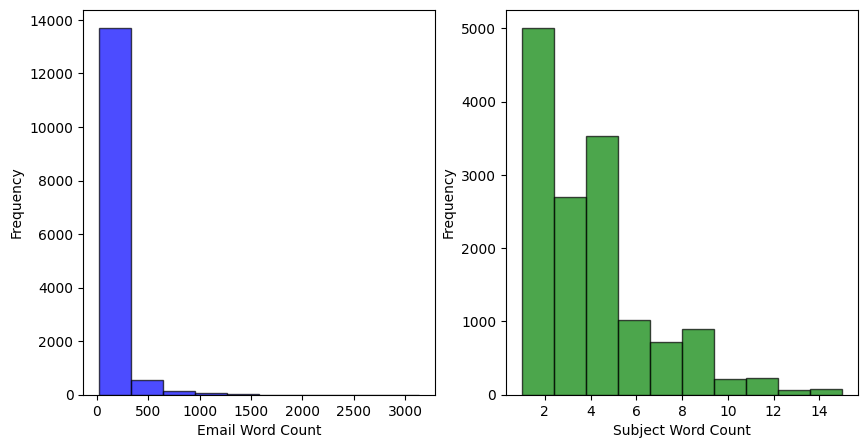

In [64]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(pivot_df['body_wcount'], bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Email Word Count')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(pivot_df['subj_wcount'], bins=10, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Subject Word Count')
plt.ylabel('Frequency')


In [65]:
def plot_correlation(df, title, dataset, width, height, fontsize):
    """
    Plot a heatmap of the correlation matrix for the given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    title (str): Title of the plot.
    dataset (str): Name of the dataset.
    width (int): Width of the plot.
    height (int): Height of the plot.
    fontsize (int): Font size for the plot labels.
    """
    plt.figure(figsize=(width / 100, height / 100))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title(f'{title} - {dataset}', fontsize=fontsize)
    plt.xticks(rotation=45, fontsize=fontsize-2)
    plt.yticks(rotation=0, fontsize=fontsize-2)
    plt.show()

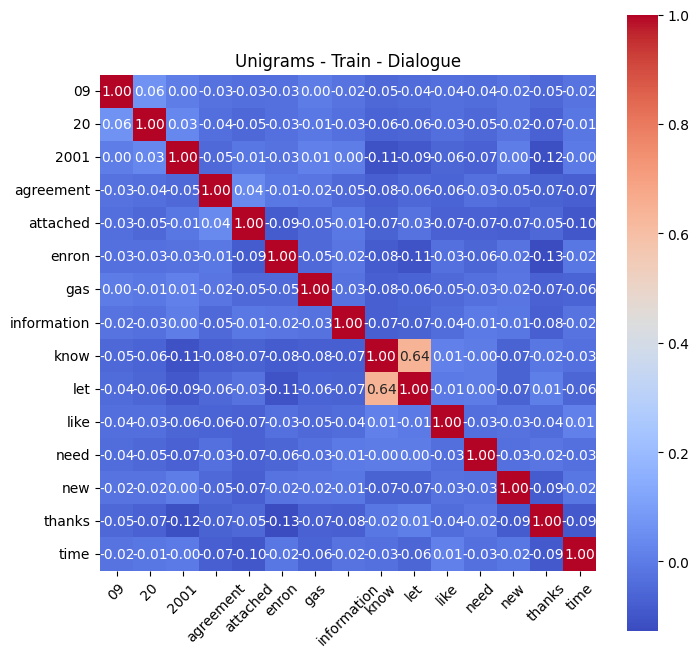

In [66]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(pivot_df['body'])
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Train - Dialogue', 800, 800, 12)

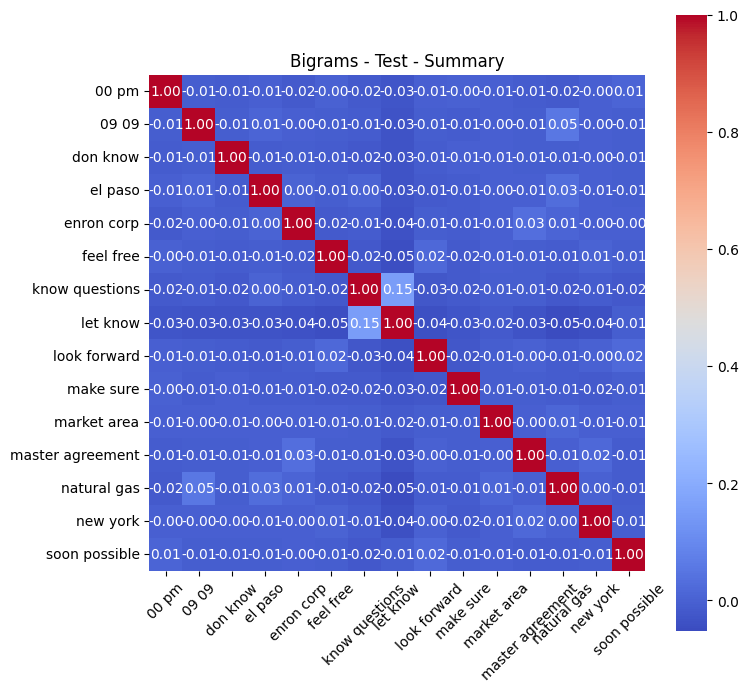

In [67]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(pivot_df['body'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Test - Summary', 800, 800, 12)

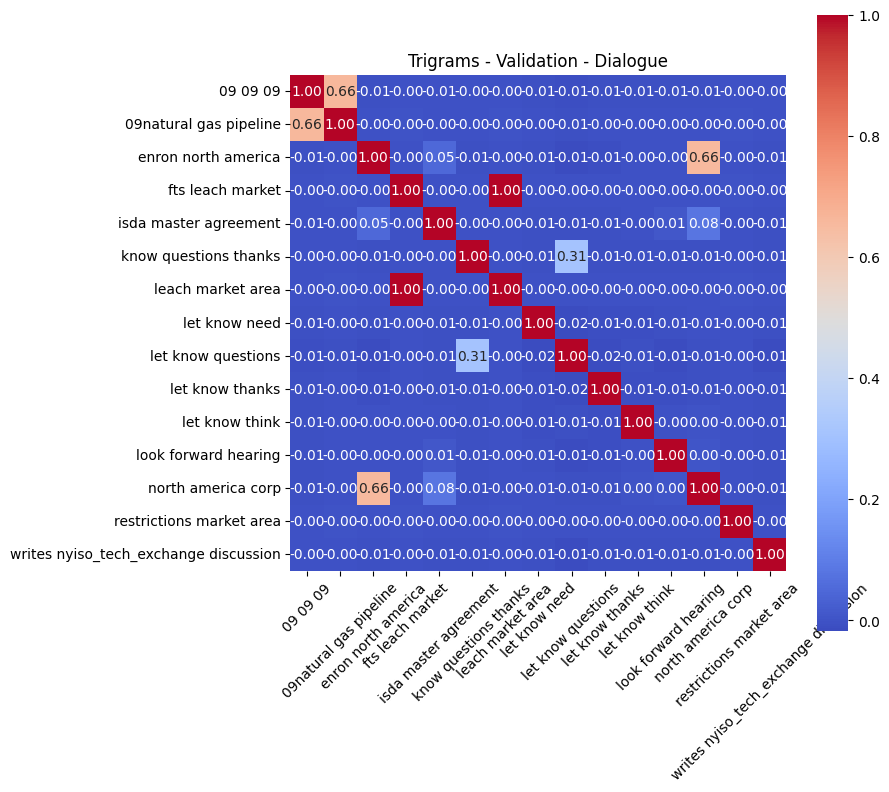

In [68]:

vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(pivot_df['body'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Validation - Dialogue', 800, 800, 12)

In [69]:
nan_rows = pivot_df[pivot_df.isna().any(axis=1)]


In [70]:
len(pivot_df['body'][0])


429

In [71]:
pivot_df['body'][0][0:2]

'Gr'

In [72]:
pivot_df['body'][1]

'Phillip & Keith  Attached is the first draw request, I will need some of these funds immediately.\nI think checks out of Bishops Corner, L.P. may be the easiest, or you can wire money to me and I can write the checks when needed.\nPlease let me know how you wish to handle this and I will proceed.\nAdditionally, it is getting close to closing.\nI will need to get contracts signed at this point as soon as possible.\nWe can handle this in two ways.\nI prefer that you elect me as a Vice - President of the General Partner and then I will sign all documents, or I can Federal Express contracts (this is more difficult).\nI have a funeral at 10:00 and I will be back about 1:00.\nI look forward to hearing from you.\nGreg     - Draw # 1 - 10.25.01.xls'

In [74]:
# Assuming your DataFrame is named 'data' with columns 'text' and 'label' (adjust names if needed)
text_data = pivot_df['body'].tolist()
summary_data = pivot_df['subject'].tolist()

In [75]:
len(text_data), len(summary_data)

(14436, 14436)

In [76]:
pivot_df

tag,source,body,subject,ann0,ann1,ann2,body_wcount,subj_wcount,cleaned_emails
0,allen-p_inbox_20,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement,NaN,NaN,NaN,65,2,gregphillip attached is the grande communicati...
1,allen-p_inbox_28,Phillip & Keith Attached is the first draw re...,Bishops Corner,NaN,NaN,NaN,145,2,phillip keith attached is the first draw reque...
2,allen-p_inbox_63,Your Internet Banking accounts are now setup a...,Internet Banking,NaN,NaN,NaN,250,2,your internet banking accounts are now setup a...
3,allen-p_inbox_64,To our IBS Customers that are still hanging in...,Internet Banking,NaN,NaN,NaN,458,2,to our ibs customers that are still hanging in...
4,allen-p_inbox_65,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories,NaN,NaN,NaN,68,4,phillip good morning i hope you had a wonderfu...
...,...,...,...,...,...,...,...,...,...
14431,zufferli-j_inbox_43,This email is acknowledgement from the Power P...,Power Pool,NaN,NaN,NaN,227,2,this email is acknowledgement from the power p...
14432,zufferli-j_inbox_44,This email is acknowledgement from the Power P...,Power Pool of Alberta,NaN,NaN,NaN,277,4,this email is acknowledgement from the power p...
14433,zufferli-j_inbox_46,"John, Further to the voice message that I lef...",Enron Security,NaN,NaN,NaN,148,2,john further to the voice message that i left ...
14434,zufferli-j_inbox_8,Make sure that all curves are downloaded by th...,Simulation Curves,NaN,NaN,NaN,66,2,make sure that all curves are downloaded by th...


**Test Train Split**

In [77]:
train_df, test_df = train_test_split(pivot_df, test_size=0.2, random_state=42)

In [100]:
train_df

tag,source,body,subject,ann0,ann1,ann2,body_wcount,subj_wcount,cleaned_emails
2238,dasovich-j_sent_4499,Met early this morning with Jack Steward (pres...,Follow-up Meeting this Morning w/CMA,NaN,NaN,NaN,350,5,met early this morning with jack steward pres....
8437,nemec-g_inbox_286,Gerald: I have been contacted by Kim Torres o...,"Sale of Napoleonville, LA property, Our file ...",NaN,NaN,NaN,36,8,gerald i have been contacted by kim torres of ...
14177,wolfe-j_inbox_187,We are in need of the following information: ...,Important Information Needed!!!!!!!!!,NaN,NaN,NaN,34,3,we are in need of the following information em...
3971,haedicke-m_inbox_1051,I have a concern about Enron's forward-looking...,Another Version of Negative CTC Risk?,NaN,NaN,NaN,136,6,i have a concern about enrons forwardlooking e...
7976,mclaughlin-e_inbox_147,"Errol, Here are the bankruptcy post-id's that...",BANKRUPTCY POST-ID'S,NaN,NaN,NaN,71,2,errol here are the bankruptcy postids that nee...
...,...,...,...,...,...,...,...,...,...
5191,jones-t_sent_306,I've found a great website to check on utiliti...,Great Web Site,NaN,NaN,NaN,41,3,ive found a great website to check on utilitie...
13418,thomas-p_inbox_313,"Gentlemen, I have created a new file to track...","Replacement for ""Big Deal""",NaN,NaN,NaN,81,4,gentlemen i have created a new file to track o...
5390,jones-t_sent_648,We received a Notice from the NYMEX today that...,NYMEX ACCESS,NaN,NaN,NaN,46,2,we received a notice from the nymex today that...
860,buy-r_inbox_157,This has got to be the last time.\nTomorrow mo...,The Maple Leaves,NaN,NaN,NaN,131,3,this has got to be the last time. tomorrow mor...


**Load the pre-trained FLAN-T5 model and its tokenizer directly from HuggingFace. This is a small version of FLAN-T5.
Setting torch_dtype=torch.bfloat16 specifies the memory type to be used by this model.**

In [83]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer


In [84]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [96]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"Trainable model parameters: {trainable_model_params}\nAll model parameters: {all_model_params}\nPercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"



In [99]:
print("For Model : FLAN-T5 \n",print_number_of_trainable_model_parameters(original_model))

For Model - FLAN-T5: 
 Trainable model parameters: 247577856
All model parameters: 247577856
Percentage of trainable model parameters: 100.00%


**Test the Model with Zero Shot Inferencing**

In [101]:
train_df['cleaned_emails'][0]

'gregphillip attached is the grande communications service agreement. the business points can be found in exhibit c. i can get the nondisturbance agreement after it has been executed by you and grande. i will fill in the legal description of the property one i have received it. please execute and send to grande communications 401 carlson circle san marcos texas 78666 attention hunter williams. bishopscontract.doc'

**Using a pre-trained model from Hugging Face, such as t5-small, to fine-tune on your dataset and generate subject lines.**

In [111]:
index = 20

email = train_df['cleaned_emails'][index]
subject = train_df['subject'][index]

prompt = f"""
Generate the subject line for the following email.

Email:
{email}

Subject:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens=5,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN ANNOTED SUBJECT LINE :\n{subject}\n')
print(dash_line)
print(f'FLAN-T5 MODEL GENERATION - ZERO SHOT SUBJECT LINE:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Generate the subject line for the following email.

Email:
john as discussed the aig exposure is 57mm and it is distributed among the price option and exotic books. the attached spreadsheet details the dollar value and volume by month by book. please call if you have questions. tanya

Subject:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN ANNOTED SUBJECT LINE :
AIG positions

---------------------------------------------------------------------------------------------------
FLAN-T5 MODEL GENERATION - ZERO SHOT SUBJECT LINE:
aig exposure


# **Performing Full Fine-Tuning**

In [112]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

NameError: name 'dataset' is not defined

In [80]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

# Convert DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Initialize tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
T5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [78]:


# Tokenization
def preprocess_data(examples):
    inputs = ["generate subject line: " + email for email in examples['cleaned_emails']]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['subject'], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()



tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/11548 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# # Generate subject lines for the test set
# def generate_subject_line(email_body):
#     inputs = tokenizer("generate subject line: " + email_body, return_tensors="pt", max_length=512, truncation=True)
#     # Move inputs to the same device as the model
#     inputs = {k: v.to(model.device) for k, v in inputs.items()}
#     outputs = model.generate(inputs.input_ids, max_length=128, num_beams=4, early_stopping=True)
#     return tokenizer.decode(outputs[0], skip_special_tokens=True)

# test_df['generated_subject_line'] = test_df['cleaned_emails'].apply(generate_subject_line)

# Generate subject lines for the test set
def generate_subject_line(email_body):
    inputs = tokenizer("generate subject line: " + email_body, return_tensors="pt", max_length=512, truncation=True)
    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    # Access input_ids as a key in the dictionary
    outputs = model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_df['generated_subject_line'] = test_df['cleaned_emails'].apply(generate_subject_line)

# **t5-small Evaluation**

In [ ]:
!pip install nltk
import nltk
from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score
# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [ ]:


# Download the 'punkt' resource
nltk.download('punkt')
nltk.download('wordnet') # Download WordNet

from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score
# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)


# Evaluate the generated subject lines
def evaluate_metrics(true_subject, generated_subject):
    # Tokenize the input for METEOR
    true_subject_tokens = nltk.word_tokenize(true_subject)
    generated_subject_tokens = nltk.word_tokenize(generated_subject)

    # ROUGE-L
    rougeL = scorer.score(true_subject, generated_subject)['rougeL'].fmeasure

    # METEOR
    meteor = meteor_score([true_subject_tokens], generated_subject_tokens) # Pass tokenized input

    # SACREBLEU - Use import sacrebleu directly
    sacre_bleu_score = sacrebleu.corpus_bleu([generated_subject], [[true_subject]]).score

    return rougeL, meteor, sacre_bleu_score # Return the score, not the module

test_df['rougeL'], test_df['meteor'], test_df['sacrebleu'] = zip(*test_df.apply(
    lambda row: evaluate_metrics(row['subject'], row['generated_subject_line']), axis=1))

# Calculate average scores
average_rougeL = test_df['rougeL'].mean()
average_meteor = test_df['meteor'].mean()
average_sacrebleu = test_df['sacrebleu'].mean() # Now you should be able to calculate the mean

print(f'Average ROUGE-L: {average_rougeL:.4f}')
print(f'Average METEOR: {average_meteor:.4f}')
print(f'Average SACREBLEU: {average_sacrebleu:.4f}')

# **Pretrained('facebook/bart-base')**

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

In [ ]:
# Convert DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Initialize tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
facebook_bart_base_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Tokenization
def preprocess_data(examples):
    inputs = ["generate subject line: " + email for email in examples['body']]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['subject'], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define Trainer
facebook_bart_base_model_trainer = Trainer(
    model=facebook_bart_base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
facebook_bart_base_model_trainer.train()


In [ ]:
# Save the model locally
model_save_path = "./facebook_bart_base"
facebook_bart_base_model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")

In [ ]:
# Generate subject lines for the test set
def generate_subject_line(email_body):
    inputs = tokenizer("generate subject line: " + email_body, return_tensors="pt", max_length=512, truncation=True)
    # Move inputs to the GPU if available
    inputs = {k: v.to(facebook_bart_base_model.device) for k, v in inputs.items()}
    # Access input_ids from the dictionary
    outputs = facebook_bart_base_model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_df['generated_subject_line'] = test_df['body'].apply(generate_subject_line)

In [ ]:
test_df

In [ ]:

import nltk
from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score

In [ ]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)


# Evaluate the generated subject lines
def evaluate_metrics(true_subject, generated_subject):
    # Tokenize the input for METEOR
    true_subject_tokens = nltk.word_tokenize(true_subject)
    generated_subject_tokens = nltk.word_tokenize(generated_subject)

    # ROUGE-L
    rougeL = scorer.score(true_subject, generated_subject)['rougeL'].fmeasure

    # METEOR
    meteor = meteor_score([true_subject_tokens], generated_subject_tokens) # Pass tokenized input

    # SACREBLEU - Use import sacrebleu directly
    sacre_bleu_score = sacrebleu.corpus_bleu([generated_subject], [[true_subject]]).score

    return rougeL, meteor, sacre_bleu_score # Return the score, not the module

test_df['rougeL'], test_df['meteor'], test_df['sacrebleu'] = zip(*test_df.apply(
    lambda row: evaluate_metrics(row['subject'], row['generated_subject_line']), axis=1))

In [ ]:

# Calculate average scores
average_rougeL = test_df['rougeL'].mean()
average_meteor = test_df['meteor'].mean()
average_sacrebleu = test_df['sacrebleu'].mean() # Now you should be able to calculate the mean

print(f'Average facebook_bart_base_model ROUGE-L: {average_rougeL:.4f}')
print(f'Average facebook_bart_base_model METEOR: {average_meteor:.4f}')
print(f'Average facebook_bart_base_model SACREBLEU: {average_sacrebleu:.4f}')

In [ ]:
import shutil
from google.colab import files

# Replace 'directory_name' with the name of your directory
shutil.make_archive('/content/facebook_bart_base_model', 'zip', 'facebook_bart_base_model')

In [ ]:
# files.download('facebook_bart_base_model.zip')

# **t5-base**

In [ ]:
t5-base

In [ ]:
# Define tokenizer and model t5-base
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")


In [ ]:
dataset = Dataset.from_pandas(pivot_df)

In [ ]:
dataset

In [ ]:
def preprocess_function(pivot_df):
    inputs = pivot_df['cleaned_emails']
    targets = pivot_df['subject']
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)


In [ ]:
import shutil
from google.colab import files

# Replace 'directory_name' with the name of your directory
shutil.make_archive('/content/fine_tuned_t5', 'zip', 'fine_tuned_t5')

# Download the zipped directory


In [ ]:
# files.download('fine_tuned_t5.zip')

In [ ]:
tokenized_dataset

In [ ]:
# tokenized_dataset['attention_mask']
# tokenized_dataset['input_ids']

In [ ]:
# Split the dataset into train and test sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# Data collator for padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    # predict_with_generate=True,
    logging_dir="./logs",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train the model
trainer.train()

In [ ]:
model.save_pretrained('fine_tuned_t5')
tokenizer.save_pretrained('fine_tuned_t5')

In [ ]:
# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

In [ ]:
def generate_summary(text):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', max_length=512, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary



In [ ]:
# Example inference
example_text = pivot_df['body'][3]
print("Email Body:", example_text)
print("\n\n Generated Subject:", generate_summary(example_text))
print("\n\n Actual Subject:", pivot_df['subject'][3])

In [ ]:
from rouge_score import rouge_scorer
import sacrebleu
from nltk.translate.meteor_score import meteor_score

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Evaluate the generated subject lines
def evaluate_metrics(true_subject, generated_subject):
    # ROUGE-L
    rougeL = scorer.score(true_subject, generated_subject)['rougeL'].fmeasure

    # METEOR
    meteor = meteor_score([true_subject], generated_subject)

    # SACREBLEU
    sacre_bleu = sacrebleu.corpus_bleu([generated_subject], [[true_subject]]).score

    return rougeL, meteor, sacre_bleu

test_df['rougeL'], test_df['meteor'], test_df['sacrebleu'] = zip(*test_df.apply(
    lambda row: evaluate_metrics(row['subject_line'], row['generated_subject_line']), axis=1))

# Calculate average scores
average_rougeL = test_df['rougeL'].mean()
average_meteor = test_df['meteor'].mean()
average_sacrebleu = test_df['sacrebleu'].mean()

print(f'Average ROUGE-L: {average_rougeL:.4f}')
print(f'Average METEOR: {average_meteor:.4f}')
print(f'Average SACREBLEU: {average_sacrebleu:.4f}')

In [ ]:
import re

def extract_sentences(text):
  """
  This function extracts sentences from text without introducing control characters.

  Args:
      text (str): The text to be processed.

  Returns:
      list: A list of extracted sentences.
  """
  # Split text based on sentence boundaries (adjust pattern as needed)
  sentences = re.split(r"(?<!\w)\.(?!\w)", text)

  # Remove empty elements and leading/trailing whitespace
  sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

  return sentences

# Example usage
text = "This is an example text. It contains multiple sentences.  \nThere are also newlines and extra spaces."
extracted_sentences = extract_sentences(pivot_df['body'][0])
print(extracted_sentences)


NameError: name 'pivot_df' is not defined

In [ ]:
pivot_df['body'][0]

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
summary = summarizer(pivot_df['body'][0], max_length=15, min_length=2, do_sample=False)
print(summary[0]['summary_text'])

NameError: name 'pipeline' is not defined

In [ ]:
pivot_df['body'][0]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("Chirayu/subject-generator-t5-base")
tokenizer = AutoTokenizer.from_pretrained("Chirayu/subject-generator-t5-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def get_subject(content, num_beams=5,max_length=512, repetition_penalty=2.5, length_penalty=1, early_stopping=True,top_p=.95, top_k=50, num_return_sequences=3):

  text =  "title: " + content + " </s>"

  input_ids = tokenizer.encode(
    text, return_tensors="pt", add_special_tokens=True
  )

  input_ids = input_ids.to(device)
  generated_ids = model.generate(
      input_ids=input_ids,

      num_beams=num_beams,
      max_length=max_length,
      repetition_penalty=repetition_penalty,
      length_penalty=length_penalty,
      early_stopping=early_stopping,
      top_p=top_p,
      top_k=top_k,
      num_return_sequences=num_return_sequences,
  )
  subjects = [tokenizer.decode(generated_id,skip_special_tokens=True,clean_up_tokenization_spaces=True,) for generated_id in generated_ids]
  return subjects

In [ ]:
x = get_subject(pivot_df['body'][0])
x

In [ ]:
pivot_df['body'][0]

In [ ]:
pivot_df['body'][1]

In [ ]:
import textwrap

In [ ]:
def text_summarizer(email_text):

    model_name = "facebook/bart-large-cnn"
    model = BartForConditionalGeneration.from_pretrained(model_name)
    tokenizer = BartTokenizer.from_pretrained(model_name)

    inputs = tokenizer.encode("summarize: " + email_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=100, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    formatted_summary = "\n".join(textwrap.wrap(summary, width=80))
    return formatted_summary

summary = text_summarizer(pivot_df['body'][0])
summary

In [ ]:
def extract_sentences(text):
    """
    Extract sentences from the text and remove newline characters.

    Parameters:
    text (str): The text to process.

    Returns:
    list: A list of sentences without newline characters.
    """
    # Replace newline characters with spaces
    text = text.replace('\n', '')
    text = text.replace('!', '.').replace('?', '.').replace(';', '.')

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    return sentences

# Example usage
sample_text = "Hello, world!\nThis is a test.\nLet's replace, commas, and newlines."
sentences = extract_sentences(sample_text)
for sentence in sentences:
    print(sentence)

In [ ]:
summary = text_summarizer(pivot_df['body'][0])
summary

In [ ]:
pivot_df['body'][0]

In [ ]:
email_len = [len(pivot_df['dialogue'].split()) for x in samsum['train']]
sub_len = [len(pivot_df['summary'].split()) for x in samsum['train']]

dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]



In [ ]:
describe_df(pivot_df)

In [ ]:
nan_rows

In [ ]:
from langchain.preprocessing import Tokenizer, Lowercaser, PunctuationRemover, StopwordRemover
from langchain.stemming import Stemmer
from langchain import Pipeline

In [ ]:
len(email_docs)*3

In [ ]:
emails_df['content'][0]

In [ ]:
emails_df['source'][0]

In [ ]:
extract_file_name(emails_df['source'][0])